# Starting point with the refactored LMI codebase
## Working with a custom dataset

### Steps:
1. Loading the configuration setting
2. Loading the descriptors
3. Building the LMI
4. Searching in LMI
5. Running k-NN search with LMI
6. Visualizing the result

In [83]:
%reload_ext autoreload
%autoreload 2

In [48]:
from utils import load_yaml, load_model_config
from data.SimpleDataLoader import SimpleDataLoader
from indexes.LearnedMetricIndex import LMI

### 1. Loading the config settings

In [86]:
config = load_yaml('./config/config-simple.yml')
config

{'setup': 'lmi-test',
 'data': {'data-dir': '/storage/brno12-cerit/home/tslaninakova/data/test',
  'dataset-file': 'simple-data.csv',
  'queries': 'simple-queries.txt',
  'knn-gt': 'simple-knn.json',
  'normalize': False,
  'shuffle': True},
 'LMI': {'model-config': './config/model-gmm.yml', 'n_levels': 2},
 'experiment': {'output-dir': 'outputs',
  'search-stop-conditions': [0.0005,
   0.001,
   0.003,
   0.005,
   0.01,
   0.05,
   0.1,
   0.2,
   0.3,
   0.5],
  'knns': 30}}

### 2. Loading the descriptors

In [87]:
loader = SimpleDataLoader(config['data'])
df = loader.load_descriptors()
df.head()

[2021-10-19 16:15:32,407][INFO ][data.SimpleDataLoade] Loading dataset from /storage/brno12-cerit/home/tslaninakova/data/test/simple-data.csv.


Sample        ecc            N   gammaG       Esoil         Econc  \
729   730.0  11.625850  3948.023438  0.95699  114.363274  32521.521484   
254   255.0  19.085159  3170.881348  1.03283   80.459648  33391.855469   
917   918.0  11.142500  3433.740723  1.09978   49.611118  34447.597656   
879   880.0  24.354731  4316.699219  1.02849   95.203102  34488.367188   
765   766.0  13.812410  2082.017578  1.06051   59.120979  32433.710938   

          Dbot       H1       H2       H3      Mr_t      Mt_t      Mr_c  \
729  19.261681  1.26294  1.20946  1.41062 -1.649546 -0.662982  1.716038   
254  18.692020  1.05278  1.78297  1.45705 -2.018919 -1.097921  3.041059   
917  20.807421  1.24750  1.51041  1.29790 -1.544692 -0.463211  1.967141   
879  21.519890  0.82069  1.68712  0.83487 -3.837519 -2.057460  5.719089   
765  21.107430  1.20807  1.49864  1.08284 -1.009079 -0.375391  1.550380   

         Mt_c  
729  1.597773  
254  1.978373  
917  1.457650  
879  3.164923  
765  1.057488

In [88]:
# Useful if you've got a large dataset and want to test LMI building on a smaller portion first
#from utils import sample
#df_test = sample(df, None, 1000)

### 3. Building the Learned Metric Index

In [53]:
lmi = LMI(config['LMI'], df)

[2021-10-19 16:02:28,663][INFO ][indexes.BaseIndex] Created an empty LMI of 2 levels to be built on a dataset of size: (1000, 14).


In [54]:
model_config = load_model_config(config['LMI']['model-config'], lmi.n_levels)
model_config

{'level-0': {'model': 'GMM',
  'n_components': 5,
  'covariance_type': 'diag',
  'max_iter': 20,
  'init_params': 'kmeans'},
 'level-1': {'model': 'GMM',
  'n_components': 5,
  'covariance_type': 'diag',
  'max_iter': 20,
  'init_params': 'kmeans'}}

In [55]:
lmi.data.X.head()

Sample        ecc            N   gammaG       Esoil         Econc  \
73     74.0  13.738840  4682.752930  1.05993   66.911827  32577.599609   
596   597.0   0.000000  4862.626465  1.02026   77.879822  30300.978516   
809   810.0  10.873850  3704.298096  0.94988   86.118629  33402.691406   
392   393.0   0.000000  2542.484863  0.94442   70.959251  35163.144531   
430   431.0  19.682051  2128.005371  1.03651  101.820068  36738.214844   

          Dbot       H1       H2       H3      Mr_t      Mt_t      Mr_c  \
73   21.840019  1.24736  1.40285  1.39109 -2.127267 -1.009885  3.458615   
596  22.648500  1.26891  1.70003  1.53991  0.187645  0.141033  0.187645   
809  19.810881  1.25427  1.20868  1.52257 -1.357392 -0.590293  2.225520   
392  20.993271  0.83695  1.80337  1.58914  0.145515  0.102728  0.145515   
430  22.745689  1.19284  1.70503  0.84884 -1.915723 -0.679261  2.117158   

         Mt_c  
73   2.240616  
596  0.141033  
809  1.374952  
392  0.102728  
430  1.459782

In [56]:
lmi.data.y.head()

L1   L2
73   NaN  NaN
596  NaN  NaN
809  NaN  NaN
392  NaN  NaN
430  NaN  NaN

In [57]:
%time lmi.train(model_config, rebuild=True)

[2021-10-19 16:02:29,741][INFO ][indexes.BaseIndex] Training model M.0 (root) on dataset(1000, 14) with {'model': 'GMM', 'n_components': 5, 'covariance_type': 'diag', 'max_iter': 20, 'init_params': 'kmeans'}.
[2021-10-19 16:02:29,772][INFO ][indexes.BaseIndex] Training level 1 with {'model': 'GMM', 'n_components': 5, 'covariance_type': 'diag', 'max_iter': 20, 'init_params': 'kmeans'}.
[2021-10-19 16:02:29,863][INFO ][indexes.BaseIndex] Finished training the LMI.


CPU times: user 122 ms, sys: 3.73 ms, total: 126 ms
Wall time: 124 ms


In [58]:
lmi.data.y.head()

L1   L2  L1_pred  L2_pred
73   NaN  NaN        3        3
596  NaN  NaN        2        1
809  NaN  NaN        0        3
392  NaN  NaN        2        4
430  NaN  NaN        0        3

#### Interesting attributes of LMI - `model_stack` and `objects_in_buckets`

In [59]:
lmi.model_stack

[LMIGaussianMixtureModel(node_id=()),
 [LMIGaussianMixtureModel(node_id=(0,)),
  LMIGaussianMixtureModel(node_id=(1,)),
  LMIGaussianMixtureModel(node_id=(2,)),
  LMIGaussianMixtureModel(node_id=(3,)),
  LMIGaussianMixtureModel(node_id=(4,))]]

`lmi.objects_in_buckets` is a dictionary of every bucket (=key) and the number of objects it holds (=value). Using this structure we can e.g. plot the histogram of bucket occupancies

<BarContainer object of 25 artists>

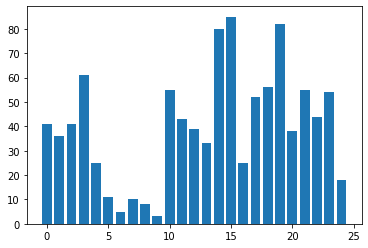

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
occupancies = list(lmi.objects_in_buckets.values())
plt.bar([i for i in range(len(occupancies))], occupancies)

### 4. Searching in LMI

In [61]:
%time search_results, times, visited_objects_all = lmi.search(lmi.data.X.iloc[0].name, [50])
search_results, times, visited_objects_all

[2021-10-19 16:02:37,847][INFO ][indexes.BaseIndex] Finished searching for query 73, stop condition=50, visited 56 objects in total, took 0.0s.


CPU times: user 3.58 ms, sys: 0 ns, total: 3.58 ms
Wall time: 3.28 ms


([[(3, 3)]], [0.0018093585968017578], [56])

In [62]:
# A more detailed look at searching - prints out the priority queue
import logging
lmi.LOG.setLevel(logging.DEBUG)

In [63]:
%time search_results, times, visited_objects_all = lmi.search(lmi.data.X.iloc[0].name, [500])

[2021-10-19 16:02:38,747][DEBUG][indexes.BaseIndex] -> -1.0, p=1.0 | PQ: []
[2021-10-19 16:02:38,749][DEBUG][indexes.BaseIndex] -> (3,), p=0.9999924565907052 | PQ: [[(4,) 7.245480829602771e-06]
 [(0,) 2.97928467274356e-07]
 [(1,) 1.2997588495195962e-85]]
[2021-10-19 16:02:38,750][DEBUG][indexes.BaseIndex] -> (3, 3), p=0.9906295861279817 | PQ: [[(3, 0) 0.0093699690837147]
 [(4,) 7.245480829602771e-06]
 [(3, 2) 4.433353888891917e-07]]
[2021-10-19 16:02:38,751][DEBUG][indexes.BaseIndex] -> (3, 0), p=0.0093699690837147 | PQ: [[(4,) 7.245480829602771e-06]
 [(3, 2) 4.433353888891917e-07]
 [(0,) 2.97928467274356e-07]]
[2021-10-19 16:02:38,752][DEBUG][indexes.BaseIndex] -> (4,), p=7.245480829602771e-06 | PQ: [[(3, 2) 4.433353888891917e-07]
 [(0,) 2.97928467274356e-07]
 [(3, 4) 1.452915869293827e-09]]
[2021-10-19 16:02:38,754][DEBUG][indexes.BaseIndex] -> (4, 1), p=0.9999999970573086 | PQ: [[(3, 2) 4.433353888891917e-07]
 [(0,) 2.97928467274356e-07]
 [(4, 2) 2.942688045858957e-09]]
[2021-10-19 

CPU times: user 14.8 ms, sys: 9.85 ms, total: 24.7 ms
Wall time: 18.7 ms


### 5. Running k-NN search

In [110]:
knns = loader.get_knn_ground_truth()
queries = loader.get_queries()

In [111]:
from Experiment import Evaluator
e = Evaluator(lmi, knns, queries, config)

In [112]:
# Let's hide the detailed logging
import logging
lmi.LOG.setLevel(logging.INFO)

In [113]:
# outputs are saved in 'outputs/*current-datetime*'
e.run_evaluate()
e.generate_summary()

[2021-10-19 16:27:41,743][INFO ][Experiment] Results will be saved to outputs/2021-10-19--16-27-41.
[2021-10-19 16:27:41,748][INFO ][indexes.BaseIndex] Finished searching for query 861, stop condition=0, visited 11 objects in total, took 0.0s.
[2021-10-19 16:27:41,749][INFO ][indexes.BaseIndex] Finished searching for query 861, stop condition=1, visited 11 objects in total, took 0.0s.
[2021-10-19 16:27:41,750][INFO ][indexes.BaseIndex] Finished searching for query 861, stop condition=3, visited 11 objects in total, took 0.01s.
[2021-10-19 16:27:41,750][INFO ][indexes.BaseIndex] Finished searching for query 861, stop condition=5, visited 11 objects in total, took 0.01s.
[2021-10-19 16:27:41,751][INFO ][indexes.BaseIndex] Finished searching for query 861, stop condition=10, visited 11 objects in total, took 0.01s.
[2021-10-19 16:27:41,752][INFO ][indexes.BaseIndex] Finished searching for query 861, stop condition=50, visited 52 objects in total, took 0.01s.
[2021-10-19 16:27:41,753][INFO

### 6. Visualize
Assumes that a summary was generated using `Evaluator`

x: [0, 1, 3, 5, 10, 50, 100, 200, 300, 500] | x_tick_labels: [0.0005, 0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]


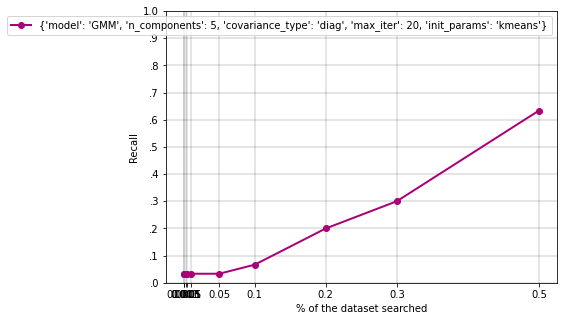

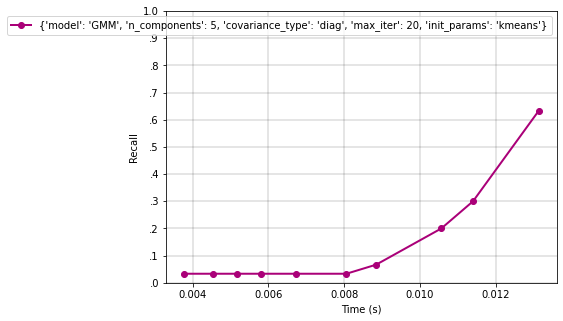

In [118]:
from visualization import Plot
plot = Plot([e.job_id])
plot.get_experiment_infos()
plot.plot_experiments(save=True)